# The Visual Storyteller

This notebook presents the construction of an image captioning model that generates natural language descriptions for images.

The approach combines a convolutional neural network (CNN) for visual feature extraction with a long short-term memory (LSTM) network for sequential caption generation.

The Flickr8k dataset is used, with captions preprocessed and transformed into a vocabulary suitable for training.

### Directory Structure

If manual dataset setup is preferred, the `caption_data` folder (approximately 1.04 GB) should be placed in the same directory as this notebook. This folder contains the image files and the corresponding caption annotations required for training.


```
.
├── data_and_training.ipynb     # data loading, preprocessing, training
├── inference.ipynb             # caption generation using trained model
├── *.py                        # model, dataset, and utility modules
│
├── trained/                    # saved model (.pth files)
│
└── caption_data/               # dataset directory
    ├── Images/                 # all image files
    │   ├── image_0001.jpg
    │   ├── ...
    │   └── image_N.jpg
    │
    └── captions.txt            # image captions

```

Hyperparameters used throughout notebook in one place:
```
IMAGE_PATH = './caption_data/Images'
CAPTIONS_PATH = './caption_data/captions.txt'
VOCAB_PATH = './trained/vocab.pkl'
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1
DROPOUT = 0.5
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
MIN_WORD_FREQ = 3  # filter words that appear less than this

START, END, PAD, UNKNOWN = '<START>', '<END>', '<PAD>', '<UNK>'
```

# Preliminary Analysis

Load the text data and save it as a panda dataframe for easy modification later on. Each image has 5 different captions.

In [12]:
import pandas as pd

IMAGE_PATH = './caption_data/Images'
CAPTIONS_PATH = './caption_data/captions.txt'

df = pd.read_csv(CAPTIONS_PATH)
print(df.head())

                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


`captions.txt` includes mapping between images and captions i.e. IMAGE_NAME.jpg -> CAPTION.

In [13]:
num_images = df["image"].nunique()
print(f"\nNumber of unique images: {num_images}")


Number of unique images: 8091


Image dataset is composed of everyday images of people or animals in action. Let's have a look at some of the pictures together with the captions.

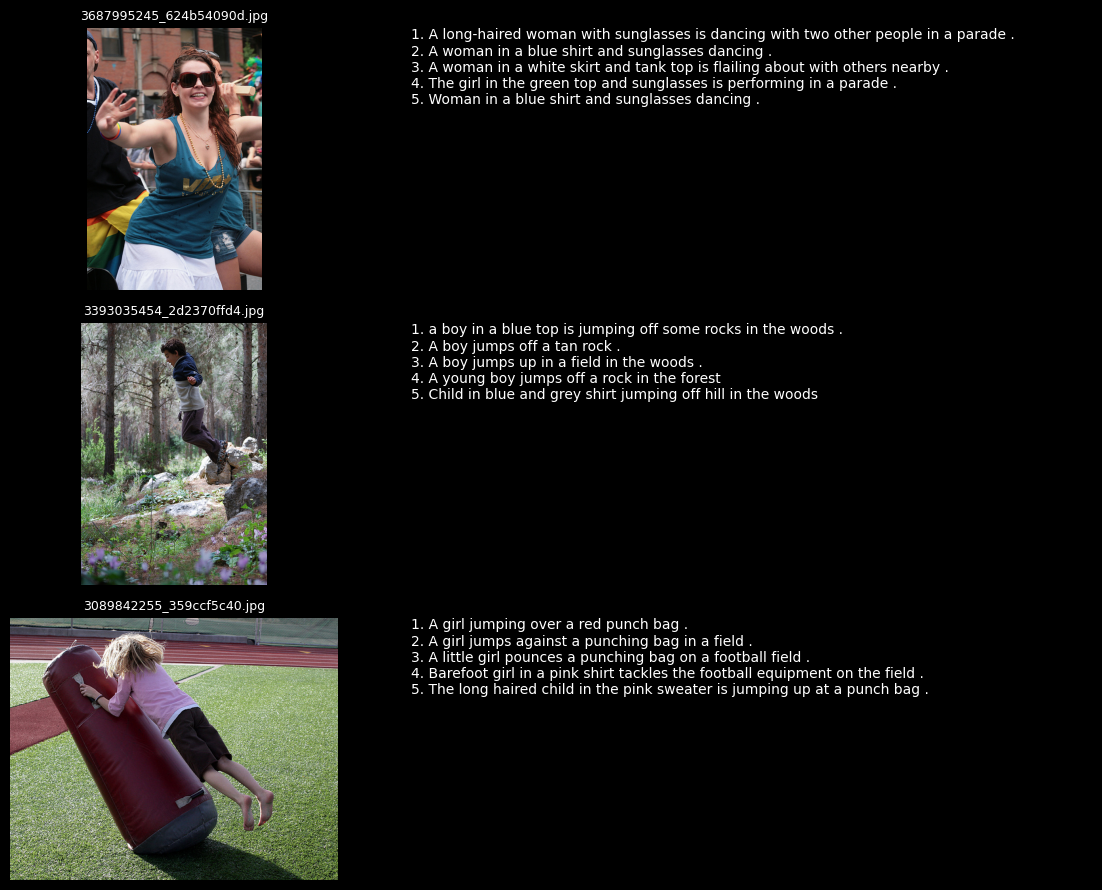

In [14]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# pick random images
num_of_images = 3
image_files = random.sample(df["image"].unique().tolist(), num_of_images)

fig, axes = plt.subplots(len(image_files), 2, figsize=(14, 3 * len(image_files)))

for i, img_name in enumerate(image_files):
    # load image
    img_path = os.path.join(IMAGE_PATH, img_name)
    image = Image.open(img_path).convert("RGB")

    # get all captions for this image
    captions = df[df["image"] == img_name]["caption"].tolist()

    # left: image
    axes[i, 0].imshow(image)
    axes[i, 0].axis("off")
    axes[i, 0].set_title(img_name, fontsize=9)

    # right: captions as text
    axes[i, 1].axis("off")
    caption_text = "\n".join([f"{j + 1}. {c}" for j, c in enumerate(captions)])
    axes[i, 1].text(0, 1, caption_text, va="top", fontsize=10, wrap=True)

plt.tight_layout()
plt.show()

# Data Preparation


In [15]:
all_words = df["caption"].str.split().explode()
vocabulary_count = all_words.value_counts()

print(f"\nNumber of unique words before filtering: {vocabulary_count.size}")
print("Most frequently used words:", vocabulary_count.keys()[:10].tolist())


Number of unique words before filtering: 9630
Most frequently used words: ['a', '.', 'A', 'in', 'the', 'on', 'is', 'and', 'dog', 'with']


Raw caption data usually comes from human-written descriptions. While natural for people, this text contains many elements that do not help a neural network learn visual–language alignment.

Examples of noisy or low-value elements: "a", "an", ",", ".", numbers or stray characters.

A larger vocabulary makes learning more difficult and slows convergence. Reducing the vocabulary size through text cleaning directly improves training efficiency.

Modification I'll be doing to caption sentences:
1. Making all letters lower case
2. Removing punctuation
3. Removing numbers
4. Removing single character words
5. Removing articles
6. Replacing multiple whitespaces with single one
7. Adding START and END sequence tokens to the sentence

Tokens are symbols the model learns to predict. Each token corresponds to an index in the vocabulary and an embedding vector.

Explanation of what each token represents:

1. START - Marks the beginning of a caption
2. END - Marks the end of a caption
3. PAD - Used to pad shorter captions so all sequences have equal length
4. UNKNOWN - Represents rare or unseen words

In [16]:
import re

START, END, PAD, UNKNOWN = '<START>', '<END>', '<PAD>', '<UNK>'


def clean_caption(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"[^\w\s]", "", sentence)  # punctuation
    sentence = re.sub(r"\d+", "", sentence)  # numbers
    sentence = re.sub(r"\b\w\b", "", sentence)  # single chars
    sentence = re.sub(r"\b(a|an|the)\b", "", sentence)  # articles
    sentence = re.sub(r"\s+", " ", sentence).strip()
    return START + ' ' + sentence + ' ' + END


df["caption_clean"] = df["caption"].apply(lambda x: clean_caption(x))
all_words_after = df["caption_clean"].str.split().explode()
vocab_after = all_words_after.value_counts()

print(f"\nNumber of unique words after filtering: {vocab_after.size}")
print("Most frequent after cleaning:", vocab_after.index[:10].tolist())


Number of unique words after filtering: 8765
Most frequent after cleaning: ['<START>', '<END>', 'in', 'on', 'is', 'and', 'dog', 'with', 'man', 'of']


Vocabulary size has decreased from 9630 to 8765, but we can make it even lower.

In [17]:
df_sample = df[["caption", "caption_clean"]].sample(3)
print("\nSample cleaned captions:")
for idx, row in df_sample.iterrows():
    print(f"\nRow {idx}:")
    print(f"  Original: {row['caption']}")
    print(f"  Cleaned : {row['caption_clean']}")


Sample cleaned captions:

Row 12995:
  Original: A green Volkswagen Bug and other vintage cars are admired by people in a courtyard .
  Cleaned : <START> green volkswagen bug and other vintage cars are admired by people in courtyard <END>

Row 38908:
  Original: Two dogs , one with its mouth open .
  Cleaned : <START> two dogs one with its mouth open <END>

Row 15518:
  Original: The man holding a newspaper is wearing a white suit , black shirt and black shoes .
  Cleaned : <START> man holding newspaper is wearing white suit black shirt and black shoes <END>


We are ready to build up our vocabulary, for which I am using standard class.

Words are mapped to indices. We keep both way mappings for easy data manipulation and later on for inference.

In [18]:
from collections import Counter


class Vocabulary:
    """Vocabulary class to handle word-to-index and index-to-word mappings"""

    def __init__(self, freq_threshold=5):
        self.itos = {0: PAD, 1: UNKNOWN, 2: START, 3: END}
        self.stoi = {PAD: 0, UNKNOWN: 1, START: 2, END: 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in sentence.split():
                frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = text.split()
        return [self.stoi.get(token, self.stoi[UNKNOWN]) for token in tokenized_text]

Another filtering step is just dropping words that are very rare. In my case if word appeared less than 3 times, it would not make it to final vocabulary.

In [19]:
MIN_WORD_FREQ = 3  # filter words that appear less than this

print("\nBuilding vocabulary...")
vocab = Vocabulary(freq_threshold=MIN_WORD_FREQ)
vocab.build_vocabulary(df["caption_clean"].tolist())
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")


Building vocabulary...
Vocabulary size: 4076


We went from vocabulary size of 9630 -> 8765 -> 4076.

This vocabulary will be important for inference later on so its better to save it as separate file.

In [20]:
import pickle

VOCAB_PATH = './trained/vocab.pkl'

with open(VOCAB_PATH, 'wb') as f:
    pickle.dump(vocab, f)
print("Vocabulary saved to vocab.pkl")

Vocabulary saved to vocab.pkl


## Train / Validation Split by Image

Images are split first, then captions are filtered accordingly.

This ensures that captions of the same image never appear in both sets.

In [21]:
from sklearn.model_selection import train_test_split

TEST_SAMPLE_SIZE = 0.2
RANDOM_SEED = 42

unique_images = df["image"].unique()
train_imgs, val_imgs = train_test_split(
    unique_images,
    test_size=TEST_SAMPLE_SIZE,
    random_state=RANDOM_SEED
)

train_df = df[df["image"].isin(train_imgs)].reset_index(drop=True)
val_df = df[df["image"].isin(val_imgs)].reset_index(drop=True)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Training samples: 32360
Validation samples: 8095


## Image Transformations

Before images can be passed into a neural network, they must be converted into a numerical format and standardized. This preprocessing step ensures that all images follow the same scale and distribution expected by the pretrained CNN.

In [22]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

`transforms.Compose([...])`

This function chains multiple transformations together and applies them in order.
Each image passes through every step listed inside the array.

`transforms.Resize((224, 224))`

- Resizes every image to 224 × 224 pixels
- This size is required by ResNet models (which I am using for encoder CNN)
- Ensures all images have the same shape, which is mandatory for batch training

`transforms.Normalize(mean, std)`

```
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
```

These values correspond to ImageNet statistics. One value per color channel. See relevant [page](https://albumentations.ai/blog/2025/03-the-mystery-of-input-normalization/).

## Custom Flickr Dataset

A custom `Dataset` class is defined to:
- Load image files
- Apply transformations
- Convert captions into numerical token sequences

In [23]:
import os
from torch.utils.data import Dataset
from PIL import Image


class FlickrDataset(Dataset):
    """Custom Dataset for Flickr8k"""

    def __init__(self, df, image_path, vocab, transform=None):
        self.df = df
        self.image_path = image_path
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image']
        caption = row['caption_clean']

        # Load image
        img_path = os.path.join(self.image_path, img_name)
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        # Numericalize caption
        caption_vec = self.vocab.numericalize(caption)
        caption_vec = torch.tensor(caption_vec)

        return img, caption_vec

## Dataset Instantiation

Training and validation datasets are created using the cleaned DataFrame and shared vocabulary.

In [24]:
train_dataset = FlickrDataset(
    train_df,
    IMAGE_PATH,
    vocab,
    transform
)

val_dataset = FlickrDataset(
    val_df,
    IMAGE_PATH,
    vocab,
    transform
)

# Batch Preparation and DataLoaders

Neural networks are trained on batches of data rather than single samples.
However, image captioning introduces an extra challenge: captions have variable lengths.
Since tensors in a batch must have the same shape, captions must be padded to a common length.

This section defines a custom collate function to handle padding and sets up PyTorch `DataLoaders`.

## Padding Index

Vocabulary defines a special `<PAD>` token used to fill shorter captions.

In [25]:
pad_idx = vocab.stoi[PAD]

- `pad_idx` is the numerical index assigned to the padding token
- This value will be used when extending captions to equal length
- Padding tokens are later ignored by the loss function during training

## Custom Collate Function

The collate function controls how individual samples are combined into a batch.

In [26]:
from torch.nn.utils.rnn import pad_sequence
import torch


class CollateFunc:
    """Custom collate function to pad sequences in a batch"""

    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        # Stack images into a single tensor
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)

        # Pad captions to the same length
        targets = [item[1] for item in batch]
        targets = pad_sequence(
            targets,
            batch_first=True,
            padding_value=self.pad_idx
        )

        return imgs, targets

What happens inside this function:
1. Images - Each image tensor is expanded with unsqueeze(0). Images are concatenated into shape: `(batch_size, channels, height, width)`
2. Captions - Captions are sequences of different lengths. `pad_sequence` adds `<PAD>` tokens to shorter captions. Final caption shape is `(batch_size, max_caption_length)`.

## DataLoaders

The `DataLoader` handles:
- batching
- shuffling
- parallel loading
- applying the collate function

In [27]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

collate_fn = CollateFunc(pad_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

Key parameters explained:
- `batch_size` - Number of image–caption pairs processed at once
- `shuffle=True` - Randomizes training samples each epoch (important for generalization)
- `collate_fn` - Applies custom padding logic defined above
- `num_workers=2` - Loads data in parallel to speed up training

# Model

The image captioning system follows an encoder–decoder architecture:

- Encoder (CNN): extracts meaningful visual features from an image
- Decoder (LSTM): generates a caption word by word based on those features

This design mirrors how humans describe images: first understanding what is visible, then expressing it as a sentence.

## Encoder: Converting Images to Feature Vectors

The encoder converts a raw image into a compact numerical representation that captures high-level visual information such as objects, shapes, and textures.

A pretrained ResNet18 model is used as the image feature extractor. This avoids training a CNN from scratch and significantly improves performance.

In [28]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

class EncoderCNN(nn.Module):
    """
    Lightweight CNN encoder using pre-trained ResNet18
    """

    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()

        # Use ResNet18 for lightweight model.
        # Trained on ImageNet (millions of images)
        # Learns general visual features useful for many tasks
        resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

        # Remove the last fully connected layer
        # The final classification layer is removed
        # because the goal is feature extraction, not image classification.
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        # Freeze ResNet parameters (optional - for faster training)
        # Reduces overfitting on a small dataset
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Projects high-dimensional CNN features into a smaller embed_size
        # Batch normalization stabilizes training
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

## Decoder: Generating Captions with LSTM

The decoder converts image features into a sequence of words, one step at a time.

An LSTM (Long Short-Term Memory) network is used because it can model word order and long-range dependencies in sentences.

In [29]:
class DecoderRNN(nn.Module):
    """
    LSTM-based decoder for caption generation
    """

    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.5):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.dropout = dropout

        # Converts word indices into dense vectors
        # Words with similar meanings get similar representations
        self.embed = nn.Embedding(vocab_size, embed_size)

        # LSTM layer, Processes word sequences
        # Maintains memory of previous words
        # batch_first=True uses (batch, sequence, features) format
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer to predict next word
        # Maps LSTM outputs to vocabulary-sized logits, representing probabilities for the next word.
        self.linear = nn.Linear(hidden_size, vocab_size)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, features, captions):
        """
        features: (batch_size, embed_size) - image features from encoder
        captions: (batch_size, seq_length) - tokenized captions
        """
        # Embed captions (excluding last word for teacher forcing)
        # Teacher forcing is used (model sees correct previous words)
        embeddings = self.embed(captions[:, :-1])

        # Concatenate image features with caption embeddings
        # Image features act as the first “word”
        # This conditions the caption on the image
        features = features.unsqueeze(1)
        embeddings = torch.cat((features, embeddings), dim=1)

        # Pass through LSTM
        hiddens, _ = self.lstm(embeddings)

        # Apply dropout and linear layer
        # Output shape (batch_size, sequence_length, vocab_size)
        outputs = self.linear(self.dropout(hiddens))

        return outputs

## Full Model Wrapper

This class combines encoder and decoder into a single model.

In [30]:
class ImageCaptioningModel(nn.Module):
    """
    Complete image captioning model combining encoder and decoder
    """

    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.5):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers, dropout)

    # Used during training.
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

---

## Model Initialization

Hyperparameters control the size, capacity, and behavior of the neural network.

1. `EMBED_SIZE = 256`

Each image and each word is converted into a 256-dimensional vector.

256 is large enough to capture meaningful information, small enough to train efficiently.

2. `HIDDEN_SIZE = 512`

Larger hidden size → better modeling of sentence structure

512 is standard choice for sequence models. Large enough to model grammar and context Pairs well with `EMBED_SIZE = 256`.

3. `NUM_LAYERS = 1`

Number of stacked LSTM layers. 1 layer is enough. Its simpler, easier to train, less overfitting on small datasets like Flickr8k.

4. `DROPOUT = 0.5`

50% of neurons are randomly ignored at each training step. 0.5 is common default with strong regularization.

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# hyperparameters
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1
DROPOUT = 0.5

print("\nInitializing model...")
model = ImageCaptioningModel(EMBED_SIZE, HIDDEN_SIZE, vocab_size, NUM_LAYERS, DROPOUT).to(device)
print("\nModel initialized!")

Using device: cpu

Initializing model...

Model initialized!


## Loss Function, Optimizer, and Learning Rate Scheduler

`nn.CrossEntropyLoss` is used for multi-class classification problems.

In image captioning, the model predicts one word at a time from the entire vocabulary, making this loss function a natural choice.

The Adam optimizer is used to update model parameters during training. It combines momentum and adaptive learning rates. Converges faster than basic gradient descent.

Learning rate scheduler (`ReduceLROnPlateau`) automatically reduces the learning rate when training stops improving.

Configuration:
- `mode='min'`: monitors a loss value
- `factor=0.5`: halves the learning rate when triggered
- `patience=3`: waits for 3 epochs without improvement before reducing

In [32]:
import torch.optim as optim

LEARNING_RATE = 0.001 # default

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

# Training

Training occurs in epochs, where the model sees all training images once per epoch. Each batch is passed through the model to compute predictions and loss.

Gradients are computed and used to update model weights. A learning rate scheduler adjusts the optimizer to improve convergence.

Validation evaluates model performance on unseen data. The best model (lowest val loss) is saved.

## Train Loop




In [33]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0

    for idx, (imgs, captions) in enumerate(dataloader):
        imgs = imgs.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()
        outputs = model(imgs, captions)

        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item()

        if (idx + 1) % 100 == 0:
            print(f"  Batch [{idx + 1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    return total_loss / len(dataloader)

## Validation Loop

In [34]:
def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for imgs, captions in dataloader:
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions)
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
import time

NUM_EPOCHS = 20

print("\nStarting training...")
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    print(f"\nEpoch [{epoch + 1}/{NUM_EPOCHS}]")

    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)

    epoch_time = time.time() - start_time
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s")

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'vocab_size': vocab_size,
        }, 'best_model.pth')
        print(f"Best model saved with val loss: {val_loss:.4f}")

print("\nTraining completed!")

On a local machine, training takes approximately 15 minutes per epoch. Training of model with manually defined layers took me 2.5 hours per epoch. That's the main reason I went with pretrained weight model.

The currently saved model was trained for 18 epochs, with the final logged metrics:

`Train Loss: 1.7923, Val Loss: 3.1934, Time: 872.73s`

Although the loss values remain relatively high, inference results show that the model is able to generate coherent and descriptive captions. Additional training epochs would further improve caption quality.

This notebook covers the full training pipeline: dataset loading, caption cleaning and normalization, vocabulary construction, train–validation splitting, data loading, model definition, and optimization. These steps establish the foundation required for reliable inference in the following notebook.